In [1]:
import clusters.algs as algs
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from csv import reader
from scipy.stats import mode
from sklearn.decomposition import PCA

2.1: Explain the distance metric you utilized to calculate the similarity/dissimilarity between small molecules.

I used Tanimoto distance as my distance metric. The primary reason behind this choice is that our ECFP data is categorical, which rules out typical distance metrics such as euclidian of manhattan. Hamming distance would be appropriate for our data type, but it is not a good choice for our data as it treats matches between zeros and matches between ones as identical, which does not represent our data well as only the ones represent biological significance. Tanimoto distance is appropriate for both our data type, and it's biological underpinning, and can be implemented though matrix algebra for fast computation time.

2.2: Use a dimensionality reduction algorithm (PCA, t-SNE, UMAP, etc) to generate a 2D visualization of the small molecule dataset. Each point should represent a single molecule. (Note: you may have to plot a subset of your data, depending on which dimensionality reduction algorithm you choose.)

In [2]:
# Import ligand data
ligand_list = algs.ligand_reader('ligand_information.csv')

In [3]:
# Convert ligand list to array

array_list = []
score_list = []

for ligand in ligand_list:
    ligand.list2array()
    array_list.append(ligand.onbits_array)
    score_list.append(ligand.score)

ligand_array = np.vstack(array_list)
score_array = np.array(score_list)

In [4]:
# Calculate principal components

pca = PCA(n_components = 2)
pca.fit(ligand_array)
pc1_ver, pc2_ver = pca.explained_variance_ratio_[0], pca.explained_variance_ratio_[1]
p = pca.transform(ligand_array)

(-4.0, 4.0)

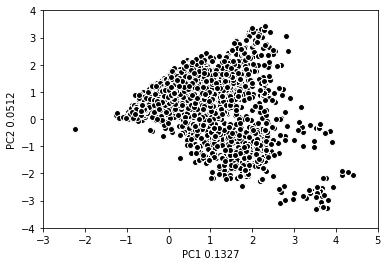

In [5]:
# Plot first two components

plt.scatter(p[:,0], p[:,1], facecolors='k', edgecolors='w')
plt.xlabel('PC1 %.4f' % (pc1_ver))
plt.ylabel('PC2 %.4f' % (pc2_ver))
plt.xlim(-3,5)
plt.ylim(-4,4)

2.3: Cluster the small molecules using your implementation of a partitioning clustering algorithm. Visualize this clustering by coloring clusters on the 2D visualization generated in question 2.

In [6]:
# Perform k-modes clustering

n_clusters = 5 # set number of clusters

kmodes = algs.PartitionClustering(ligand_array, n_clusters)
c, c_lab, p_lab_km = kmodes.cluster()

In [7]:
# Calculate principal components

a = np.concatenate((c, ligand_array), axis=0)

pca = PCA(n_components = 2)
pca.fit(ligand_array)
pc1_ver, pc2_ver = pca.explained_variance_ratio_[0], pca.explained_variance_ratio_[1]
p = pca.transform(a)

(-4.0, 4.0)

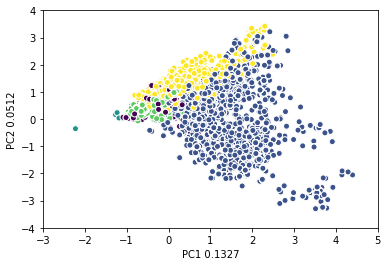

In [8]:
# Plot first two components

plt.scatter(p[0:n_clusters,0], p[0:n_clusters:,1], marker='+', c=c_lab)
plt.scatter(p[n_clusters:,0], p[n_clusters:,1], c=p_lab_km, edgecolors='w')
plt.xlabel('PC1 %.4f' % (pc1_ver))
plt.ylabel('PC2 %.4f' % (pc2_ver))
plt.xlim(-3,5)
plt.ylim(-4,4)

2.4: Explain your choice of partitioning clustering algorithm. Is it sensitive to
initialization conditions? How do you select the number of clusters?

I implemented a k-modes partitioning clustering algorithm. I chose k-modes as it is simple, has relatively low computation complexity, and has limited initialization conditions.

k-modes is very sensitive to initialization conditions as the user must specify the number of clusters to be utilized to categorize the data. Centroids are initialized through the kmeans++ algorithm, which minimizes the variance from run to run relative to random centroid selection. Moreover, the use of kmeans++ initialization generally reduces computational time as convergence is typically reached earlier than if centroids are selected randomly.

The number of clusters is specified by the user, but the elbow method or silhouette score metric could be utilized to quantitatively assist in the selection process.

2.5: Cluster the small molecules using your implementation of a hierarchical clustering algorithm. Visualize this clustering in the same way as question 3.

In [9]:
# Randomly sample from the ligand array to reduce computation time

rand_ind = np.random.choice(np.arange(0, len(ligand_array)), 1000)
ligand_array_sample = ligand_array[rand_ind]

In [10]:
# Perform single linkage hierarchical clustering

SLC = algs.HierarchicalClustering(ligand_array_sample, 0.42)
p_lab_hc = SLC.cluster()

In [11]:
# Calculate principal components

pca = PCA(n_components = 2)
pca.fit(ligand_array_sample)
pc1_ver, pc2_ver = pca.explained_variance_ratio_[0], pca.explained_variance_ratio_[1]
p = pca.transform(ligand_array_sample)

(-4.0, 4.0)

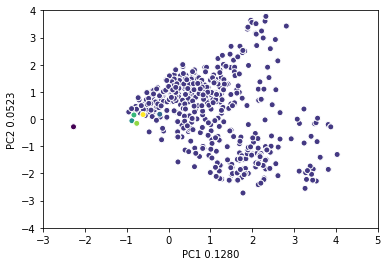

In [12]:
# Plot first two components

plt.scatter(p[:,0], p[:,1], c=p_lab_hc, edgecolors='w')
plt.xlabel('PC1 %.4f' % (pc1_ver))
plt.ylabel('PC2 %.4f' % (pc2_ver))
plt.xlim(-3,5)
plt.ylim(-4,4)

2.6: Explain your choice of hierarchical clustering algorithm. Is it sensitive to initialization conditions? How do you select the number of clusters?

I implemented a single linkage hierarchical clustering algorithm. I chose single linkage as my linkage criteria as it typically produces many small clusters. While complete linkage clustering could produce a smaller number of evenly sized clusters, I utilized SLC to see if the clusters produced with a high threshold produce one large cluster and a few small clusters of molecules which are highly differentiated in some manner. If the small clusters had an important biological meaning, this method could be more fruitful than k-modes as in the end only one to a few molecules may be investigated further.

The only parameter for the algorithm is the distance threshold for defining clusters. The clustering is extremely sensitive to this parameter and in our case setting a lower threshold can result in tens to hundreds of more clusters. With that being said, unlike k-means, this algorithm is deterministic for a given threshold value.

You do not directly set the number of clusters, but rather the distance metric threshold will yield different numbers of clusters. If you want a specific number of clusters, you could perform an analysis similar to the elbow method over different distance thresholds to see which range of distances with results in a specific number of clusters.

2.7: Evaluate the quality of both clusterings using your implementation of a clustering quality metric. Explain your choice of quality metric. Which clustering performed ‘best’ according to your metric?

In [13]:
random.seed(30)
# In order to compare between clustering algorthims, let's resample the data
# and run the algorithms on identical samples

# Randomly sample from the ligand array to reduce computation time
rand_ind = np.random.choice(np.arange(0, len(ligand_array)), 2000)
ligand_array_sample = ligand_array[rand_ind]

# Perform k-modes clustering
n_clusters = 5 # set number of clusters
kmodes = algs.PartitionClustering(ligand_array_sample, n_clusters)
c, c_lab, p_lab_km = kmodes.cluster()

# Perform single linkage hierarchical clustering
SLC = algs.HierarchicalClustering(ligand_array_sample, 0.42)
p_lab_hc = SLC.cluster()

In [14]:
# Calculate k-modes cluster silhouette score

km_ss = algs.silhouette_score(ligand_array_sample, p_lab_km)
km_ss_d = {'x': np.arange(0, len(km_ss)) ,'km_ss': km_ss, 'lab': p_lab_km}
km_ss_df = pd.DataFrame(data=km_ss_d)

In [15]:
# Calculate SLC cluster silhouette score

hc_ss = algs.silhouette_score(ligand_array_sample, p_lab_hc)
hc_ss_d = {'x': np.arange(0, len(hc_ss)) ,'hc_ss': hc_ss, 'lab': p_lab_hc}
hc_ss_df = pd.DataFrame(data=hc_ss_d)

In [16]:
# Mean silhouette score and mean cluster silhouette score

km_mcv = km_ss_df.groupby('lab').mean()['km_ss']
km_counts = km_ss_df.groupby('lab').count()['km_ss']
print(f'Mean Cluster Silhouette Score and Counts: {km_mcv, km_counts}')

Mean Cluster Silhouette Score and Counts: (lab
0    0.264881
1    0.248811
2    0.247218
3    0.399309
4    0.239386
Name: km_ss, dtype: float64, lab
0    699
1    268
2    968
3     13
4     52
Name: km_ss, dtype: int64)


In [17]:
# Mean silhouette score and mean cluster silhouette score

hc_mcv = hc_ss_df.groupby('lab').mean()['hc_ss']
hc_counts = hc_ss_df.groupby('lab').count()['hc_ss']
print(f'Mean Cluster Silhouette Score: {hc_mcv, hc_counts}')

Mean Cluster Silhouette Score: (lab
0.0    0.153412
1.0    0.036813
2.0    0.002980
3.0    0.020871
Name: hc_ss, dtype: float64, lab
0.0    1996
1.0       2
2.0       1
3.0       1
Name: hc_ss, dtype: int64)


I chose silhouette score for my clustering quality metric, as it allows cluster quality to be quantified without the use of ground truth labels.

k-modes performed best of the two algorithms. Single linkage hierarchical clustering resulted in one large cluster with a few clusters of one or two molecules. The one large SLC cluster had a poor silhouette score. In comparison, k-modes produced mutiple clusters of varying sizes, all with higher silhouette scores than single linkage hierarchical clustering.

2.8: Compare the two clusterings using your implementation of clustering similarity. How similar are the two clusterings using this function?

In [18]:
r_ind = algs.rand_index(p_lab_km, p_lab_hc)
print(f'Rand Index: {r_ind:.4f}')

Rand Index: 0.3779


The clustering labels were compared by calculating the Rand Index. As Rand Index values range from zero to one with zero meaning no simularity and one meaning identical, the score of 0.38 demonstrates that the labels between the two clustering algorithms are not very similiar.

2.9: For the “best” clustering, as determined by your quality metric, visualize the distribution of Autodock Vina scores in each cluster. Do members of the same cluster have similar docking scores? Why or why not?

In [29]:
# Create new dataframe with Autodock Vina scores

km_v_d = {'x': np.arange(0, len(km_ss)) ,'km_ss': km_ss, 
          'v_score': score_array[rand_ind], 'lab': p_lab_km}
km_v_df = pd.DataFrame(data=km_v_d)

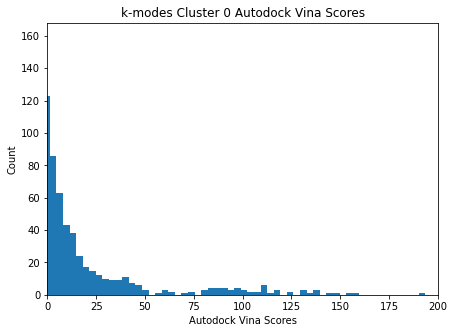

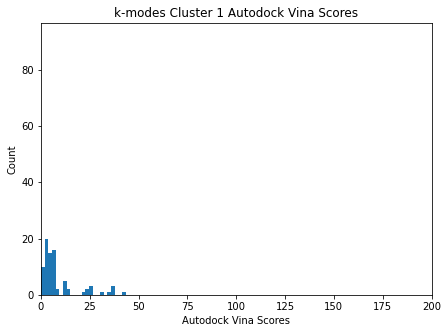

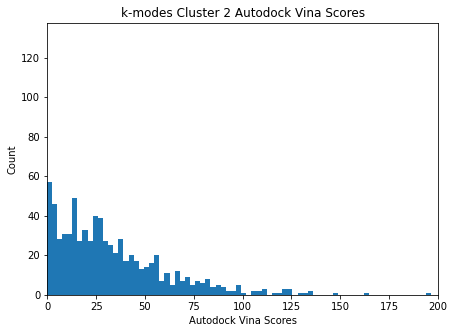

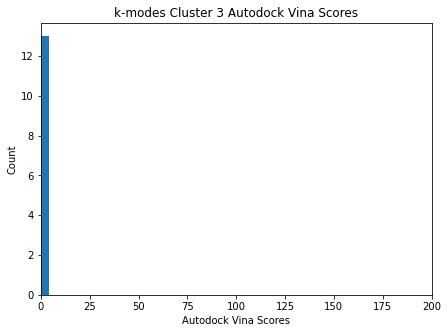

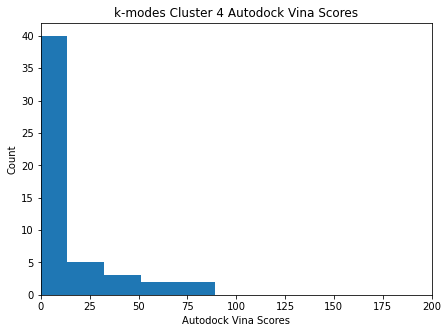

In [66]:
# Plot histograms of Autodock Vina scores in each cluster

for i in np.unique(p_lab_km):
    plt.figure(figsize=(7, 5))
    data = km_v_df[km_v_df['lab'] == i]['v_score']
    plt.hist(data, bins = int(len(data)/10), alpha=1)
    plt.xlim(0, 200)
    plt.title('k-modes Cluster %i Autodock Vina Scores' % i)
    plt.xlabel('Autodock Vina Scores')
    plt.ylabel('Count')
    plt.show()

Members of the same cluster have somewhat divergent docking scores from one another. However, there is a difference in score distribution between clusters. This result may speak to the limitations of k-modes as a clustering algorithm, or perhaps to the complex relationship between molecular structure and biological function.

2.10 Select the top scoring molecule from each cluster. This is your list of clusterheads. Visualize the top 5 by score in PyMOL and pick your favorite. Are they structurally diverse?

In [69]:
# Identify indices of clusterheads

for i in np.unique(p_lab_km):
    data = km_v_df[km_v_df['lab'] == i]['v_score']
    print(np.argmax(data))

684
121
613
9
7


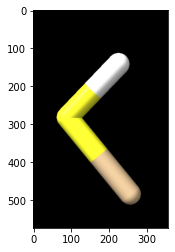

In [72]:
plt.imshow(plt.imread('7.png'))

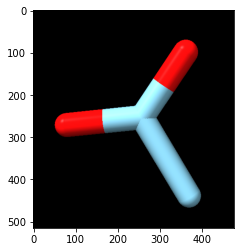

In [75]:
plt.imshow(plt.imread('9.png'))

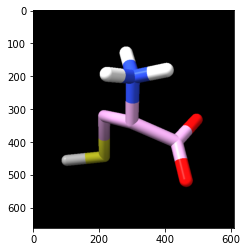

In [76]:
plt.imshow(plt.imread('121.png'))

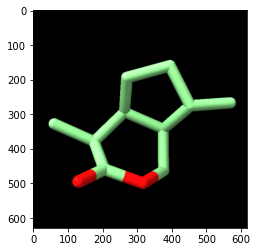

In [77]:
plt.imshow(plt.imread('613.png'))

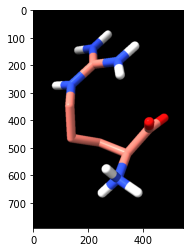

In [78]:
plt.imshow(plt.imread('684.png'))

The molecules vary somewhat in size, but not dramatically. Assuming the molecules are roughly ordered by size, these molecules are all within the bottom 10% of size.

The atomic composition of the molecules is divergent except for the presence of two oxygens towards the exterior of the molecules in molecules 9, 121, 684.

Overall I would say the molecules are structurally diverse.